# TF-IDF score: Kullback–Leibler divergence

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from scipy.stats import gaussian_kde

import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import configuration as config

/mnt/arkk/llm_detector/classifier


Load the training data.

In [2]:
# The dataset we want to bin - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
hdf5_file = f'{config.DATA_PATH}/{dataset_name}.h5'

# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Take small sample for rapid development and testing
data_df = data_df.sample(n = 5000)

# Close hdf5 connection
data_lake.close()

data_df.head()

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,Perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)
34270,34270,8388,202,269,cnn,human,human,A former Royal Marine soldier who was fired by...,2.262,2.398438,0.942997,3.751633,4.194039,7.614278,7.527886
31401,31401,4526,81,109,cc_news,human,human,is not the first time the feature has been exp...,2.666,2.880859,0.925424,1.965726,2.145340,5.314257,5.293794
47150,47150,11139,119,163,pubmed,human,human,"every population , a significant relationship ...",3.000,3.056641,0.981470,2.440100,2.676213,5.353940,5.344630
33739,33739,5663,47,144,cc_news,human,human,"ESTIMATED INVESTMENT TO $1,175 MILLION IN TOTA...",2.533,2.574219,0.984067,2.420194,2.626224,5.418749,5.403426
39946,39946,6105,271,354,cc_news,human,human,that suggested moving it.\nA group called Virg...,2.611,2.613281,0.999253,4.398247,5.004094,6.681174,6.662225


Clean up the text fragments for TF-IDF analysis.

In [3]:
# Take samples so we don't OOM during vectorization for TF-IDF
training_data_df_sample = data_df.sample(frac = 1, random_state = 42)
training_data_df_sample.reset_index(inplace = True, drop = True)

In [4]:
# Get human and synthetic text
human_texts_sample = training_data_df_sample['String'][training_data_df_sample['Source'] == 'human']
synthetic_texts_sample = training_data_df_sample['String'][training_data_df_sample['Source'] == 'synthetic']

In [5]:
# Clean for vectorization
human_texts_sample = human_texts_sample.apply(lambda x: helper_funcs.clean_text(x))
synthetic_texts_sample = synthetic_texts_sample.apply(lambda x: helper_funcs.clean_text(x))

Now, calculate TF-IDF on the human and synthetic text samples.

In [6]:
# Fit the TF-IDF vectorizer
human_tfidf_vectorizer = TfidfVectorizer()
human_tfidf_vectors = human_tfidf_vectorizer.fit_transform(human_texts_sample)

# Convert the vectors to numpy and replace zeros with NAN
human_tfidf = human_tfidf_vectors.toarray()
human_tfidf[human_tfidf == 0] = np.nan

# Take the log2 and average the columns (i.e. get average TF-IDF per word)
log_human_tfidf = np.log2(human_tfidf)
log_human_tfidf_mean = np.nanmean(log_human_tfidf, axis = 0)

# Get the words
human_features = human_tfidf_vectorizer.get_feature_names_out()


In [7]:
# Release some memory
del human_tfidf_vectorizer
del human_tfidf_vectors
_ = gc.collect()

In [8]:
# Fit the TF-IDF vectorizer
synthetic_tfidf_vectorizer = TfidfVectorizer() 
synthetic_tfidf_vectors = synthetic_tfidf_vectorizer.fit_transform(synthetic_texts_sample)

# Convert the vectors to numpy and replace zeros with NAN
synthetic_tfidf = synthetic_tfidf_vectors.toarray()
synthetic_tfidf[synthetic_tfidf == 0] = np.nan

# Take the log2 and average the columns (i.e. get average TF-IDF per word)
log_synthetic_tfidf = np.log2(synthetic_tfidf)
log_synthetic_tfidf_mean = np.nanmean(log_synthetic_tfidf, axis = 0)

# Get the words
synthetic_features = synthetic_tfidf_vectorizer.get_feature_names_out()

In [9]:
# Release some memory
del synthetic_tfidf_vectorizer
del synthetic_tfidf_vectors
_ = gc.collect()

In [10]:
# Make the look-up tables
tfidf_luts = {
    'human': dict(zip(human_features, log_human_tfidf_mean)),
    'synthetic': dict(zip(synthetic_features, log_synthetic_tfidf_mean))
}

In [11]:
# Score the text fragments
fragment_scores = helper_funcs.score_known_text_fragments(data_df, tfidf_luts)
human_scores = np.asarray(fragment_scores['human'])
synthetic_scores = np.asarray(fragment_scores['synthetic'])

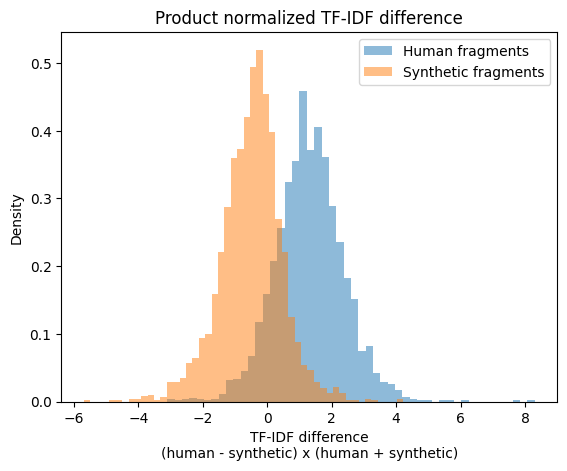

In [12]:
plt.title('Product normalized TF-IDF difference')
plt.hist(human_scores, density = True, bins = 50, label = 'Human fragments', alpha = 0.5)
plt.hist(synthetic_scores, density = True, bins = 50, label = 'Synthetic fragments', alpha = 0.5)
plt.xlabel('TF-IDF difference\n(human - synthetic) x (human + synthetic)')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

In [13]:
# Set up bins for the combined dataset
product_normalized_dtfidfs = []
product_normalized_dtfidfs.extend(human_scores)
product_normalized_dtfidfs.extend(synthetic_scores)

counts, bins = np.histogram(product_normalized_dtfidfs, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(human_scores, bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(synthetic_scores, bins = bins, density = True)

Next, fit the individual distributions with an exponential Gaussian:

In [14]:
# Fit an exponential gaussian to the human and synthetic scores and get fitted values for
# the bin centers calculated from the combined data

print('\nHuman fit:')
human_exp_gaussian = helper_funcs.exp_gaussian_fit(
    human_scores,
    bounds = [[0.01, 1.0], [-2.0, 2.0], [0.001, 5.0]]
)

human_exp_gaussian_values = human_exp_gaussian.pdf(bin_centers)
print(f'  Fitted values: {human_exp_gaussian_values[:3]}...')

print('\nSynthetic fit:')
synthetic_exp_gaussian = helper_funcs.exp_gaussian_fit(
    synthetic_scores,
    bounds = [[0.01, 1.0], [-2.0, 2.0], [0.001, 5.0]]
)

synthetic_exp_gaussian_values = synthetic_exp_gaussian.pdf(bin_centers)
print(f'  Fitted values: {synthetic_exp_gaussian_values[:3]}...')


Human fit:
  Shape: 0.5134893802648046
  Mean: 0.8287067008850842
  Variance: 0.9393455132647301
  Fitted values: [5.22413447e-12 1.46230830e-11 4.00440474e-11]...

Synthetic fit:
  Shape: 0.33387989695251713
  Mean: -0.7962474783639882
  Variance: 0.9085647115502422
  Fitted values: [1.15001521e-07 2.62449006e-07 5.85085835e-07]...


And for comparison, also use a guassian kernel density estimate to get the fit:

In [15]:
# Run the KDE and then get fitted values for the bin centers
human_kde = gaussian_kde(human_scores)
human_kde_values = human_kde.pdf(bin_centers)
print(f'Human KDE values: {human_kde_values[:3]}...')

synthetic_kde = gaussian_kde(synthetic_scores)
synthetic_kde_values = synthetic_kde.pdf(bin_centers)
print(f'Synthetic KDE values: {synthetic_kde_values[:3]}...')

Human KDE values: [1.14031222e-31 1.15752044e-28 7.90848417e-26]...
Synthetic KDE values: [0.00074678 0.0004687  0.00023936]...


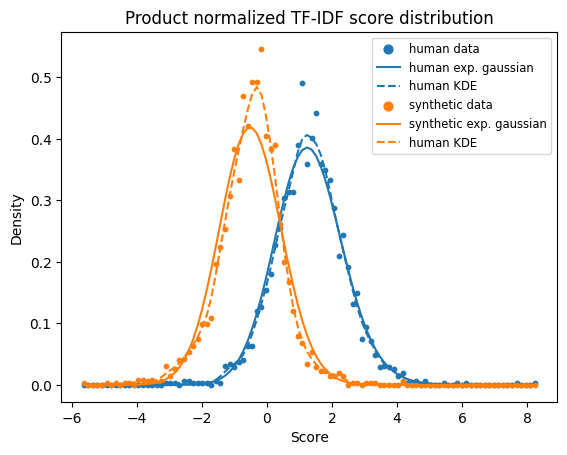

In [16]:
plot_funcs.plot_score_distribution_fits(
        'Product normalized TF-IDF score distribution',
        bin_centers,
        human_density,
        human_exp_gaussian_values,
        human_kde_values,
        synthetic_density,
        synthetic_exp_gaussian_values,
        synthetic_kde_values
).show()

Ok, looks good to me - let's take a closer look at the fits.

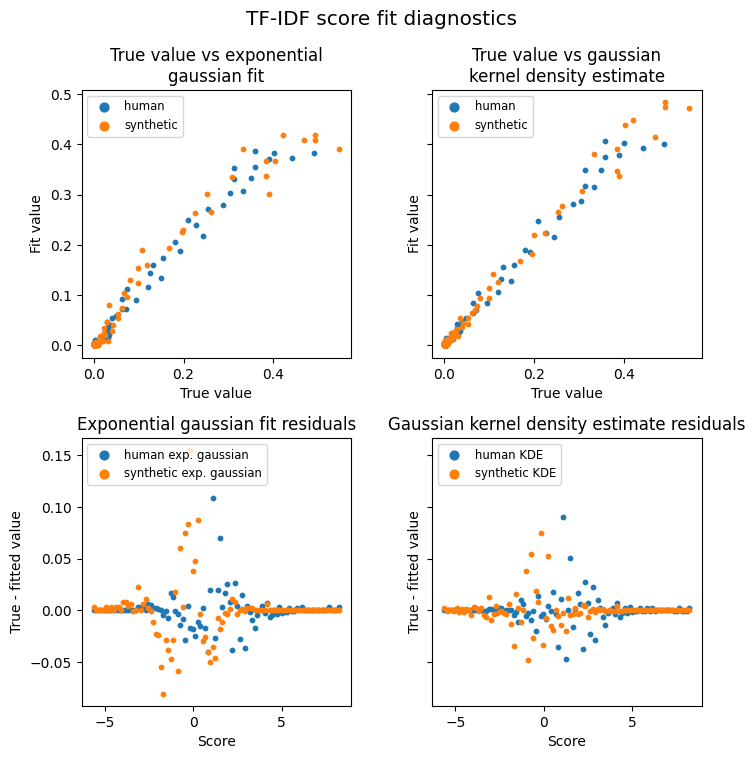

In [17]:
plot_funcs.plot_fit_diagnostics(
        'TF-IDF score fit diagnostics',
        bin_centers,
        human_density,
        synthetic_density,
        human_exp_gaussian_values,
        synthetic_exp_gaussian_values,
        human_kde_values,
        synthetic_kde_values
).show()

OK, looks good enough to me - now let's take a look at the Kullback-Leibler divergence of the two fits.

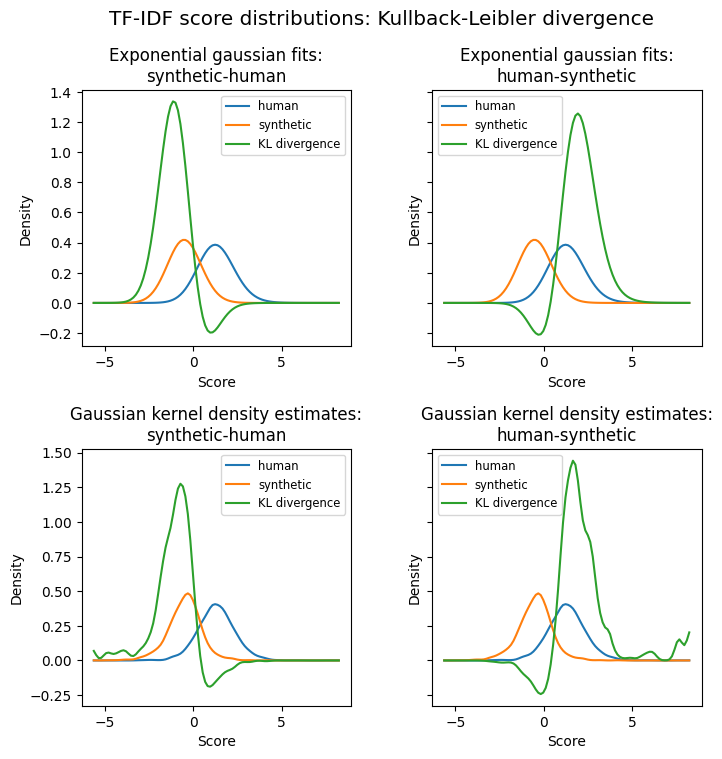

In [18]:
plot_funcs.plot_kl_divergences(
        'TF-IDF score distributions: Kullback-Leibler divergence',
        bin_centers,
        human_exp_gaussian_values,
        synthetic_exp_gaussian_values,
        human_kde_values,
        synthetic_kde_values
).show()

Sweet - I think we got it! Now, similarly to how we handled perplexity ratio score, we need a probability density function for the Kullback-Leibler divergence distribution. To do that - we need a kernel density estimate, and to do that - we need to reconstruct KL scores that would give the observed distribution.

Will calculate 1800 fitted values
Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 153
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 146


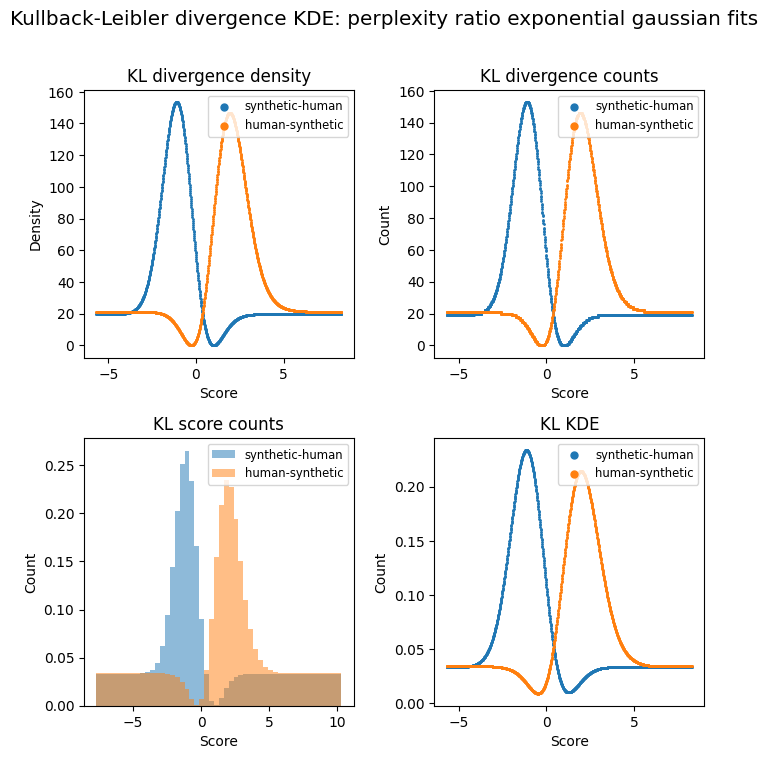

In [19]:
exp_gaussian_synthetic_human_kld_kde, exp_gaussian_human_synthetic_kld_kde, plt = helper_funcs.get_kl_kde(
    'Kullback-Leibler divergence KDE: perplexity ratio exponential gaussian fits', 
    product_normalized_dtfidfs, 
    human_exp_gaussian, 
    synthetic_exp_gaussian,
    2.0,
    0.01
)

plt.show()

Will calculate 1800 fitted values
Min synthetic-human KLD count value 0
Max synthetic-human KLD count value: 146
Min human-synthetic KLD count value 0
Max human-synthetic KLD count value: 168


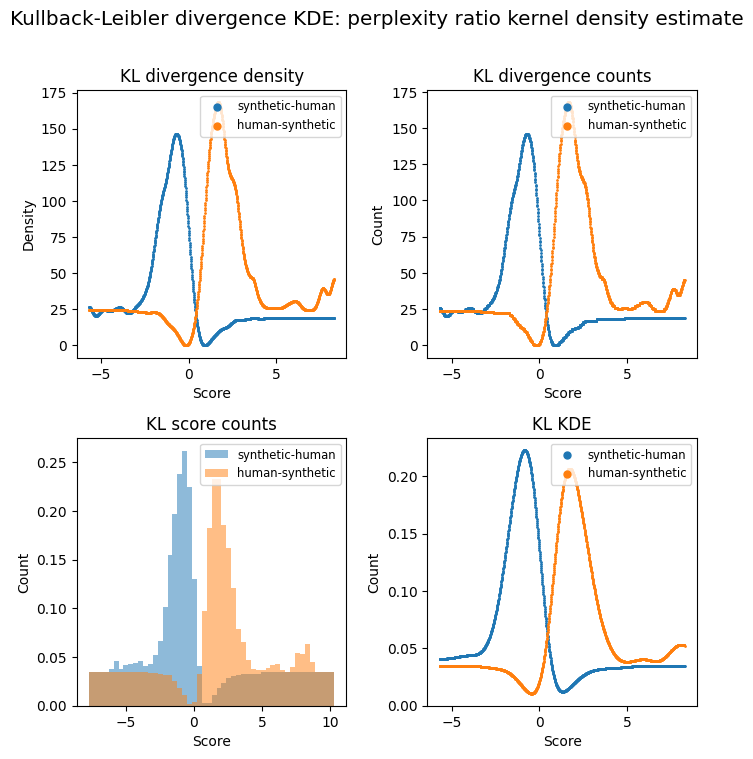

In [20]:
kde_synthetic_human_kld_kde, kde_human_synthetic_kld_kde, plt = helper_funcs.get_kl_kde(
    'Kullback-Leibler divergence KDE: perplexity ratio kernel density estimate', 
    product_normalized_dtfidfs, 
    human_kde, 
    synthetic_kde,
    2.0,
    0.01
)

plt.show()

OK, cool. Looks good. Now we can run the text fragment strings from the complete dataset through the Kullback-Leibler divergence distribution's kernel density estimate probability density function to get 'Kullback-Leibler scores' and add them to the dataframe.

In [21]:
# Score the training fragments and add new features back to dataframe
fragment_scores = helper_funcs.score_text_fragments(data_df, tfidf_luts)

data_df['Human TF-IDF'] = fragment_scores['human_tfidf']
data_df['Synthetic TF-IDF'] = fragment_scores['synthetic_tfidf']
data_df['TF-IDF score'] = fragment_scores['tfidf_score']

In [22]:
# Get the KLD scores
synthetic_human_kld_scores = exp_gaussian_synthetic_human_kld_kde.pdf(data_df['TF-IDF score'])
human_synthetic_kld_scores = exp_gaussian_human_synthetic_kld_kde.pdf(data_df['TF-IDF score'])

# Add the scores to the dataframe
data_df['Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score'] = synthetic_human_kld_scores
data_df['Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score'] = human_synthetic_kld_scores

# Get the KLD scores
synthetic_human_kld_scores = kde_synthetic_human_kld_kde.pdf(data_df['TF-IDF score'])
human_synthetic_kld_scores = kde_human_synthetic_kld_kde.pdf(data_df['TF-IDF score'])

# Add the scores to the dataframe
data_df['Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score'] = synthetic_human_kld_scores
data_df['Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'] = human_synthetic_kld_scores

Re-plot just to be sure we got the result we expected:

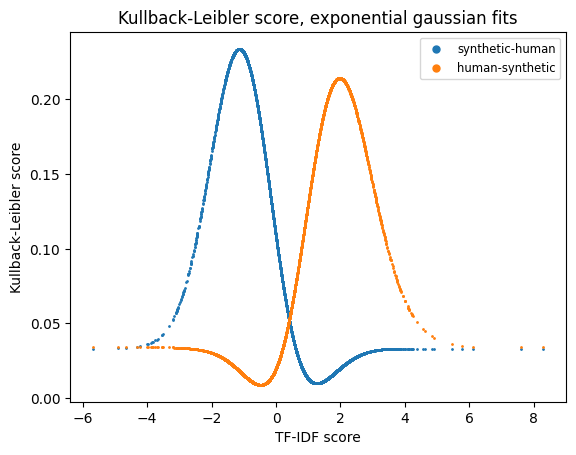

In [23]:
plt.title('Kullback-Leibler score, exponential gaussian fits')
plt.scatter(data_df['TF-IDF score'], data_df['Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data_df['TF-IDF score'], data_df['Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('TF-IDF score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

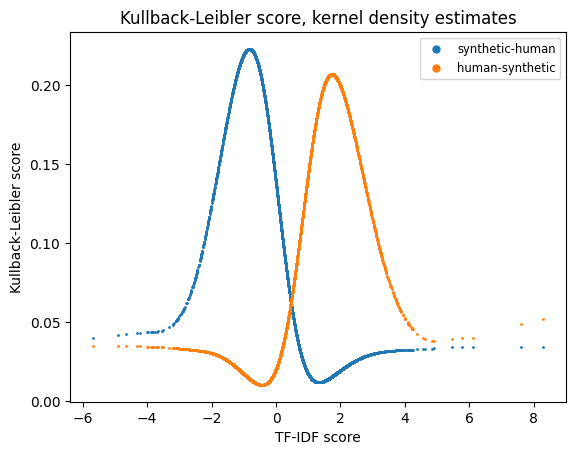

In [24]:
plt.title('Kullback-Leibler score, kernel density estimates')
plt.scatter(data_df['TF-IDF score'], data_df['Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score'], s = 1, label = 'synthetic-human')
plt.scatter(data_df['TF-IDF score'], data_df['Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score'], s = 1, label = 'human-synthetic')
plt.xlabel('TF-IDF score')
plt.ylabel('Kullback-Leibler score')
plt.legend(loc = 'upper right', fontsize = 'small', markerscale = 5)
plt.show()

Nailed it!.